## Load useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from badassdatascience.forex.database.mongodb.pull_forex_data_from_database.pull_forex_data_from_database import query_single_instrument_and_single_granularity 
from badassdatascience.forex.EDA.BadassTimeSeries import BadassTimeSeries

## User settings

These are currently hard-coded for this effort, but should this analysis become part of a pipeline I'll convert these to runtime arguments.

In [3]:
output_directory = 'output'
instrument = 'EUR/USD'
granularity = 'H1' # 'M15'

## Load the data

This pulls data from either a recently saved file or from the source Mongo database.

In [4]:
save_file = output_directory + '/df_' + instrument.replace('/', '_') + '__' + granularity + '.pickled'

df = query_single_instrument_and_single_granularity(
    instrument = instrument,
    granularity = granularity,
    pull_from_database = False,
    save_file = save_file,
)

## Visual QA #1

In [5]:
df.head(2)

,_id,volume,time,instrument,granularity,time_iso,weekday,hour,bid_o,bid_h,...,ask_c,ask_return,ask_volatility,mid_o,mid_h,mid_l,mid_c,mid_return,mid_volatility,time_iso_pd_datetime
0,68097c78da2b3e213f22f086,3,1262538000,EUR/USD,H1,2010-01-03T12:00:00-05:00,6,12,1.43070,1.43097,...,1.43247,0.00077,0.00077,1.43120,1.43172,1.43120,1.43172,0.00052,0.00052,2010-01-03 12:00:00-05:00
1,68097c78da2b3e213f22f087,137,1262541600,EUR/USD,H1,2010-01-03T13:00:00-05:00,6,13,1.43097,1.43325,...,1.43222,-0.00025,0.00348,1.43172,1.43425,1.43105,1.43157,-0.00015,0.00320,2010-01-03 13:00:00-05:00


In [6]:
df.tail(2)

,_id,volume,time,instrument,granularity,time_iso,weekday,hour,bid_o,bid_h,...,ask_c,ask_return,ask_volatility,mid_o,mid_h,mid_l,mid_c,mid_return,mid_volatility,time_iso_pd_datetime
97953,6863c0e142919cd524d22b01,7700,1751364000,EUR/USD,H1,2025-07-01T06:00:00-04:00,1,6,1.18131,1.18227,...,1.18124,-0.00021,0.00125,1.18138,1.18234,1.18110,1.18116,-0.00022,0.00124,2025-07-01 06:00:00-04:00
97954,6863cef18b3fe0e82e5f9162,7564,1751367600,EUR/USD,H1,2025-07-01T07:00:00-04:00,1,7,1.18106,1.18187,...,1.18147,0.00025,0.00136,1.18114,1.18194,1.18058,1.18140,0.00026,0.00136,2025-07-01 07:00:00-04:00


## Run additional configuration and time series processing

In [7]:
ts = BadassTimeSeries(df['time'], df['mid_c'])
ts.fit()
ts.fit_details()

/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/utilities/badass_timeseries/stationarity_and_detrending.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression = regression, nlags = nlags)
/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/utilities/badass_timeseries/stationarity_and_detrending.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression = regression, nlags = nlags)
/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/utilities/badass_timeseries/stationarity_and_detrending.py:31: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p

## Review stationarity test results

The "BadassTimeSeries" object contains four time series, each of which are tested for stationarity using both ADF and KPSS tests.

Augmented Dickey-Fuller (ADF) tests the null hypothesis that a time series has a unit root, while Kwiatkowski-Phillips-Schmidt-Shin (KPSS) tests whether the trend is stationary:

In [8]:
ts.df_stationarity_test_table

,DataFrame,test,p_value,decision,conclusion
0,original,ADF,0.128834,Fail to reject the null,Evidence suggests that the series is non-stati...
1,diff_original,ADF,0.000000,Reject the null,Evidence suggests that the series is stationary
2,filled_forward,ADF,0.118906,Fail to reject the null,Evidence suggests that the series is non-stati...
3,diff_filled_forward,ADF,0.000000,Reject the null,Evidence suggests that the series is stationary
4,original,KPSS,0.010000,Reject the null,Evidence suggests that the series is non-stati...
5,diff_original,KPSS,0.100000,Fail to reject the null,Evidence suggests that the series is trend sta...
6,filled_forward,KPSS,0.010000,Reject the null,Evidence suggests that the series is non-stati...
7,diff_filled_forward,KPSS,0.100000,Fail to reject the null,Evidence suggests that the series is trend sta...


## Use Discrete Fourier Transform to Identify Fundamental Frequencies

In [9]:
def use_dft_to_find_fundamental_frequencies(x, n_nearby = 200, n_order = 10):
    fft_x = np.fft.fft(x)
    N = len(x)
    magnitudes = np.abs(fft_x)[0:(N // 2)]
    
    # we only care about frequency magnitudes within the reasonable length of the time series we will use to train the RNN
    nearby = magnitudes[0:n_nearby] 
    
    order = np.argsort(nearby)
    return order[(-1 * n_order):]

In [10]:
frequencies_200 = use_dft_to_find_fundamental_frequencies(ts.df_diff_filled_forward['y'])
frequencies_300 = use_dft_to_find_fundamental_frequencies(ts.df_diff_filled_forward['y'], n_nearby = 300)

print(frequencies_200)
print(frequencies_300)

[166 122  41 165 161 145 191 124  57 189]
[ 41 165 161 145 191 124  57 189 283 279]


In [22]:
from badassdatascience.utilities.badass_timeseries.acf_and_pacf import center_the_ci_around_zero
from badassdatascience.utilities.badass_timeseries.acf_and_pacf import compute_acf_the_way_emily_wants_it
from badassdatascience.utilities.badass_timeseries.acf_and_pacf import compute_pacf_the_way_emily_wants_it

a_cf, acf_ci = compute_acf_the_way_emily_wants_it(ts.df_diff_filled_forward['y'], nlags = 200)
pa_cf, pacf_ci = compute_pacf_the_way_emily_wants_it(ts.df_diff_filled_forward['y'], nlags = 200)

aCI = center_the_ci_around_zero(a_cf, acf_ci)
paCI = center_the_ci_around_zero(pa_cf, pacf_ci)

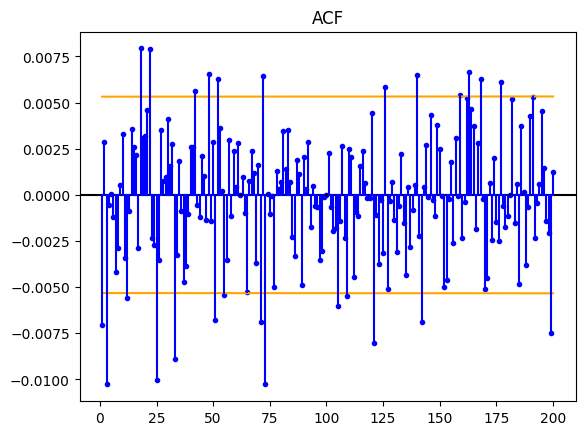

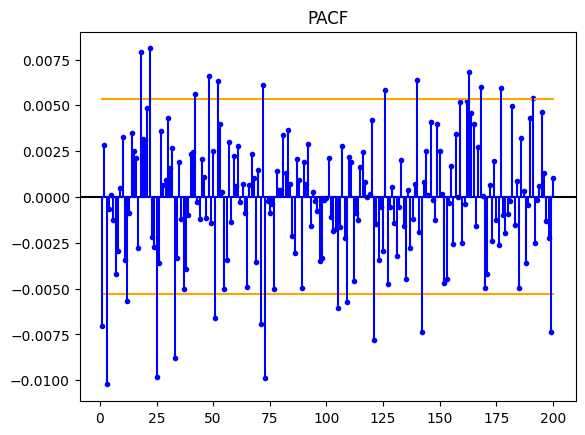

In [23]:
from badassdatascience.utilities.badass_timeseries.acf_and_pacf import plot_acf_and_pacf_the_way_emily_wants_it

plot_acf_and_pacf_the_way_emily_wants_it(a_cf, aCI, 'ACF', first_lag = 1)
plot_acf_and_pacf_the_way_emily_wants_it(pa_cf, paCI, 'PACF', first_lag = 1)

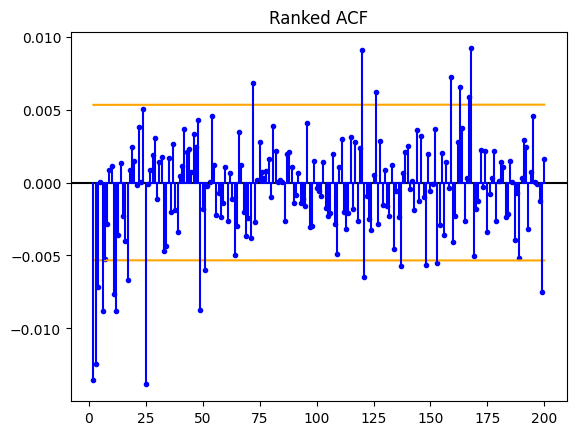

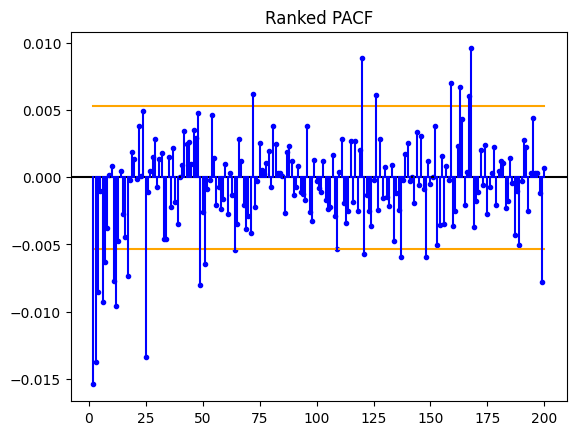

In [15]:
from scipy.stats import rankdata

x = ts.df_diff_filled_forward['y'].values

x_ranked = rankdata(x)

r_a_cf, r_acf_ci = compute_acf_the_way_emily_wants_it(x_ranked, nlags = 200)
r_pa_cf, r_pacf_ci = compute_pacf_the_way_emily_wants_it(x_ranked, nlags = 200)
r_aCI = center_the_ci_around_zero(r_a_cf, r_acf_ci)
r_paCI = center_the_ci_around_zero(r_pa_cf, r_pacf_ci)

plot_acf_and_pacf_the_way_emily_wants_it(r_a_cf, r_aCI, 'Ranked ACF', first_lag = 2)
plot_acf_and_pacf_the_way_emily_wants_it(r_pa_cf, r_paCI, 'Ranked PACF', first_lag = 2)

In [40]:
#a_cf, acf_ci

from badassdatascience.utilities.badass_timeseries.acf_and_pacf import identify_significant_indices

#def identify_significant_indices(cf, CI):
#    indices = (cf <= CI[:, 0]) | (cf >= CI[:, 1])
#    return np.arange(0, len(cf))[indices]

print(identify_significant_indices(a_cf, aCI))
print()
print(identify_significant_indices(pa_cf, paCI))
print()
print(identify_significant_indices(r_a_cf, r_aCI))
print()
print(identify_significant_indices(r_pa_cf, r_paCI))


[  0   1   3  12  18  22  25  33  42  48  51  52  55  71  72  73 105 109
 121 126 140 142 159 163 168 177 199]

[  0   1   3  12  18  22  25  33  42  48  51  52  71  72  73 105 109 121
 126 140 142 163 168 177 191 199]

[  0   1   2   3   4   6  11  12  17  25  49  51  72 120 121 126 137 148
 153 159 163 167 168 199]

[  0   1   2   3   4   6   7  11  12  17  25  49  51  64  72 109 120 121
 126 137 148 159 163 167 168 199]


In [28]:
np.min(np.int8(aCI[:, 0] <= aCI[:, 1]))

1

In [35]:
# [166 122  41 165 161 145 191 124  57 189]